# Model Analysis

The following notebook will analyze our model and identify users that performed very well on.

In [1]:
#Read in data
#Import libraries
import numpy as np
import pandas as pd
import networkx as nx

node_data = pd.read_parquet("data/node_attributes.parquet")
edge_data = pd.read_parquet("data/edges_single.parquet")
display(node_data.head())
display(edge_data.head())

,user_id,review_count,useful,funny,cool,fans,average_stars,total_compliments,days_since_yelping,years_elite,years_since_elite,Health_Beauty_Rec,Food_Dining,Shopping_Retail,Home_Services,Professional_Services,Arts_Entertainment_Party,Public_Transportation_Education,Other
0,-0xXVMZDcGw_PZMNMFOo2w,6,4,0,2,0,5.00,171,2502,0,17.0,0,0,0,0,0,0,0,1
1,-3i9bhfvrM3F1wsC9XIB8g,747,3938,2456,3314,109,4.14,3455,5953,16,0.0,0,2,0,0,0,3,2,0
2,-8Uj3PXAO-RoGz9yFupqDA,43,102,17,42,4,4.22,418,5966,0,17.0,0,1,0,0,0,1,0,0
3,-9da1xk7zgnnfO1uTVYGkA,1438,23965,16699,22215,293,4.14,33870,3520,11,0.0,0,6,1,0,0,1,2,0
4,-AKbx6qFJRw0NEcPiwovDg,46,13,1,5,0,4.41,277,1553,0,17.0,0,4,0,0,0,1,0,0


,source,target
0,--17Db1K-KujRuN7hY9Z0Q,REnIBVutnk7CBmy8auVGqg
1,--17Db1K-KujRuN7hY9Z0Q,bGu1K8WWpAWpYPCjFttiDg
2,--17Db1K-KujRuN7hY9Z0Q,ggl6fl-PM5O1WrdReL0l4A
3,uIv-QohIyddQA6JMXWsaTA,--17Db1K-KujRuN7hY9Z0Q
4,--238OiSJBDIhfqcSOQyMA,_jfMNGIbiYgyY6HEfREjXw


In [2]:
G = nx.Graph()

# Step 3: Add nodes to the graph with attributes
for idx, row in node_data.iterrows():
    node_id = row['user_id']  # Assuming 'node_id' is the column name for node IDs
    attributes = {col: row[col] for col in node_data.columns if col != 'node_id'}  # Assuming other columns are node attributes
    G.add_node(node_id, **attributes)
    
print("done with nodes\n")

# Step 4: Add edges to the graph
for idx, row in edge_data.iterrows():
    source_node = row['source']  # Assuming 'source_node' is the column name for the source node ID
    target_node = row['target']  # Assuming 'target_node' is the column name for the target node ID
    G.add_edge(source_node, target_node)
    if idx%100000 == 0:
        print(idx)

done with nodes

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000


In [3]:
# Initialize an empty dictionary to store node data
data = {}

# Initialize with node IDs and degree
data['node'] = list(G.nodes())
data['degree'] = [G.degree(n) for n in G.nodes()]

# Loop through each node in the subgraph
for n in G.nodes(data=True):
    node, attr = n
    # Loop through each attribute in the node's data
    for key, value in attr.items():
        # Check if the attribute already exists in the dictionary
        if key == "user_id":
            continue
        if key not in data:
            # If not, create a new list in the dictionary for this attribute
            data[key] = []
        # Append the attribute value to the correct list in the dictionary
        data[key].append(value)

# Some nodes might not have all attributes, fill missing values
features = pd.DataFrame(data).fillna(method='ffill')
#features = features.drop("user_id")

# Display the first few rows of the DataFrame to confirm
print(features.head())

                     node  degree  review_count  useful  funny   cool  fans  \
0  -0xXVMZDcGw_PZMNMFOo2w       4             6       4      0      2     0   
1  -3i9bhfvrM3F1wsC9XIB8g     167           747    3938   2456   3314   109   
2  -8Uj3PXAO-RoGz9yFupqDA      30            43     102     17     42     4   
3  -9da1xk7zgnnfO1uTVYGkA     127          1438   23965  16699  22215   293   
4  -AKbx6qFJRw0NEcPiwovDg       1            46      13      1      5     0   

   average_stars  total_compliments  days_since_yelping  years_elite  \
0           5.00                171                2502            0   
1           4.14               3455                5953           16   
2           4.22                418                5966            0   
3           4.14              33870                3520           11   
4           4.41                277                1553            0   

   years_since_elite  Health_Beauty_Rec  Food_Dining  Shopping_Retail  \
0               17.

/tmp/ipykernel_84324/742806122.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = pd.DataFrame(data).fillna(method='ffill')


In [6]:
import pandas as pd
from torch_geometric.data import Data
import torch
import pickle
import numpy as np
import sys

class UserIdMapper:
    """Convert user hash to integer for PyTorch Geometric data object"""
    def __init__(self, unique_users=None, dict_path=None):
        # If dict_path specified, load from this, otherwise look for the list of unique user hashes
        self.dict_path = dict_path
        if dict_path:
            self.load_from_dict()
        elif unique_users is not None:
            self.user_to_id = {user: idx for idx, user in enumerate(sorted(unique_users))}
            self.id_to_user = {idx: user for user, idx in self.user_to_id.items()}
        else:
            raise ValueError('Either unique users or dict path required.')

    def load_from_dict(self):
        """Load this object class using a dictionary mapping already saved"""
        with open(self.dict_path, 'rb') as f:
            self.user_to_id = pickle.load(f)
        self.id_to_user = {idx: user for user, idx in self.user_to_id.items()}

    def save_dict(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self.user_to_id, f)
         
    def transform(self, user):
        """Convert hash to int"""
        return self.user_to_id[user]
    
    def get_original_user(self, id):
        """Regather hash from int"""
        return self.id_to_user[id]

def prepare_edge_index(df):
    """Create torch tensor the way Data object expects edge list"""
    df_copy = df.copy()[['target', 'source']].rename(columns={'source':'target', 'target':'source'})
    df_combined = pd.concat([df, df_copy], axis=0).drop_duplicates()
    assert all(df_combined.groupby(['source', 'target']).size().unique()) == 1
    edge_index = torch.tensor(df_combined[['source', 'target']].values, dtype=torch.long).t().contiguous()
    return edge_index

def prepare_node_features(df):
    """Create torch tensor the way Data object expects node features"""
    return torch.tensor(df.values, dtype=torch.float)

def create_torch_data_object(df_edges, df_node_features, index_cols):
    # Ensure that the df_node_features is sorted based on user (so that feature_tensor[0,:] == user #0)
    df_node_features_sorted = df_node_features.sort_values('user_id', ascending=True)
    # Separate all index related information (player name, date, team, etc.)
    index = pd.concat([df_node_features_sorted.pop(col) for col in index_cols], axis=1)
    # Get tensor of edge indexes
    edge_index = prepare_edge_index(df_edges)
    # Get tensor of node features
    node_features_sorted = prepare_node_features(df_node_features_sorted)
    # Prepare Data object
    data = Data(x=node_features_sorted, edge_index=edge_index)
    return index, data

# Define a function to split edge indices into train and test sets
def split_edges(edge_index, train_ratio=0.65, val_ratio=0.20):
    num_edges = edge_index.shape[1]
    num_train = int(num_edges * train_ratio)
    num_val = int(num_edges * val_ratio)

    # Randomly permute edges
    indices = np.random.RandomState(seed=42).permutation(num_edges)

    # Create sets
    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train+num_val]
    test_indices = indices[num_train+num_val:]
    return edge_index[:, train_indices], edge_index[:, val_indices], edge_index[:, test_indices]

In [7]:
# Read in
df_edges = pd.read_parquet('data/edges_double.parquet')
df_node_features = pd.read_parquet('data/node_attributes.parquet')
print('Data read.',file=sys.stderr)

# Convert user hash to an ID
unique_user_in_edges = df_edges['source'].unique().sort()
unique_users = df_node_features['user_id'].unique().sort()
assert (unique_user_in_edges == unique_users), "All users part of edges must be in node attribute data frame"

# List of unique users
unique_users = df_node_features['user_id'].unique()
user_id_mapper = UserIdMapper(unique_users=unique_users)

Data read.


In [ ]:
10722
[156486, 37867, 66173, 192007, 55811, 203467, 104377, 82060, 162509, 144310]
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [8]:
user_id_mapper.get_original_user(10722)

'1kdfj_PaRk8i870ghdIvXg'

In [20]:
friends_hash = [10722, 156486, 37867, 66173, 192007, 55811, 203467, 104377, 82060, 162509, 144310]
friends_id = []
for hash_id in friends_hash:
    friends_id.append(user_id_mapper.get_original_user(hash_id))

In [10]:
display(features[features["node"]=='1kdfj_PaRk8i870ghdIvXg'])

,node,degree,review_count,useful,funny,cool,fans,average_stars,total_compliments,days_since_yelping,years_elite,years_since_elite,Health_Beauty_Rec,Food_Dining,Shopping_Retail,Home_Services,Professional_Services,Arts_Entertainment_Party,Public_Transportation_Education,Other
58854,1kdfj_PaRk8i870ghdIvXg,871,601,2265,799,1185,208,3.78,3629,4197,12,0.0,4,31,6,2,2,10,5,1


In [22]:
# Assuming 'features' is your DataFrame and 'friends_id' is a list of IDs.
# Step 1: Filter the DataFrame to include only the rows where 'node' is in 'friends_id'
all_users = features[features["node"].isin(friends_id)]

# Step 2: Set 'node' as the index and reindex based on 'friends_id' to match the order
friends_of_10722 = all_users.set_index('node').reindex(friends_id).reset_index()


In [23]:
display(friends_of_10722)

,node,degree,review_count,useful,funny,cool,fans,average_stars,total_compliments,days_since_yelping,years_elite,years_since_elite,Health_Beauty_Rec,Food_Dining,Shopping_Retail,Home_Services,Professional_Services,Arts_Entertainment_Party,Public_Transportation_Education,Other
0,1kdfj_PaRk8i870ghdIvXg,871,601,2265,799,1185,208,3.78,3629,4197,12,0.0,4,31,6,2,2,10,5,1
1,cRswprTqOiV1riVO25EqIw,636,1956,7219,2696,5016,199,3.75,2531,2730,8,0.0,1,10,3,0,0,4,1,0
2,8lEywHSvti2UjFP8ODbnHg,2908,1392,14476,5155,10034,346,3.46,6934,4278,10,0.0,0,2,0,0,0,1,0,0
3,G6DsO7ViO-XX7_xQF4Y3OA,416,337,4451,2970,3848,109,4.20,3384,4471,1,5.0,1,0,0,0,0,1,0,0
4,lVrNac8ldvymVo6K8yHeWA,318,224,926,389,600,56,4.06,1314,3086,9,0.0,0,1,0,0,0,0,0,0
5,DOj9NanlJP3xntULCy5Uow,1305,615,5769,2828,3783,358,4.03,10263,4898,15,0.0,0,1,0,0,0,0,0,0
6,oXBhr-GbxjceT-g1UjBqLw,1603,846,15574,8118,13998,257,4.12,5406,2560,7,0.0,10,19,6,2,0,14,9,0
7,PtLRuZrcS7qlIWP_ZXIREg,214,250,907,222,549,44,4.36,876,2446,6,0.0,0,5,2,0,0,4,2,0
8,K8VSrOOCdXS9VX5S66W4GQ,303,1633,18574,14070,16465,258,3.66,6889,4516,12,0.0,1,17,2,0,1,6,3,2
9,dyEc-BsP_qPzIWyiMW0BPw,155,600,2783,1146,1991,102,3.99,2577,4582,12,0.0,0,4,1,1,0,4,4,0


In [28]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assume 'df' is your DataFrame.

# Exclude the 'node' column from scaling
features_to_scale = friends_of_10722.drop('node', axis=1)

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features to scale
scaled_features = scaler.fit_transform(features_to_scale)

# Convert the scaled array back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Include the 'node' feature back into the scaled DataFrame
scaled_df['node'] = friends_of_10722['node'].values

# Rearrange columns if needed to put 'node' back to its original position
cols = ['node'] + [col for col in friends_of_10722.columns if col != 'node']
scaled_df = scaled_df[cols]
display(scaled_df)

/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,node,degree,review_count,useful,funny,cool,fans,average_stars,total_compliments,days_since_yelping,years_elite,years_since_elite,Health_Beauty_Rec,Food_Dining,Shopping_Retail,Home_Services,Professional_Services,Arts_Entertainment_Party,Public_Transportation_Education,Other
0,1kdfj_PaRk8i870ghdIvXg,0.273538,0.217667,0.076866,0.041667,0.039960,0.522293,0.355555,0.315659,0.714111,0.785714,0.0,0.4,1.000000,1.000000,1.0,1.0,0.714286,0.555556,0.5
1,cRswprTqOiV1riVO25EqIw,0.189729,1.000000,0.357276,0.178654,0.280661,0.493631,0.322222,0.202393,0.115824,0.500000,0.0,0.1,0.322581,0.500000,0.0,0.0,0.285714,0.111111,0.0
2,8lEywHSvti2UjFP8ODbnHg,1.000000,0.674365,0.768042,0.356225,0.595941,0.961783,0.000000,0.656592,0.747145,0.642857,0.0,0.0,0.064516,0.000000,0.0,0.0,0.071429,0.000000,0.0
3,G6DsO7ViO-XX7_xQF4Y3OA,0.111270,0.065242,0.200600,0.198440,0.207276,0.207006,0.822222,0.290386,0.825856,0.000000,1.0,0.1,0.000000,0.000000,0.0,0.0,0.071429,0.000000,0.0
4,lVrNac8ldvymVo6K8yHeWA,0.076320,0.000000,0.001075,0.012060,0.003204,0.038217,0.666666,0.076852,0.261011,0.571429,0.0,0.0,0.032258,0.000000,0.0,0.0,0.000000,0.000000,0.0
5,DOj9NanlJP3xntULCy5Uow,0.428317,0.225751,0.275202,0.188186,0.203192,1.000000,0.633333,1.000000,1.000000,1.000000,0.0,0.0,0.032258,0.000000,0.0,0.0,0.000000,0.000000,0.0
6,oXBhr-GbxjceT-g1UjBqLw,0.534593,0.359122,0.830192,0.570191,0.844999,0.678344,0.733333,0.498968,0.046493,0.428571,0.0,1.0,0.612903,1.000000,1.0,0.0,1.000000,1.000000,0.0
7,PtLRuZrcS7qlIWP_ZXIREg,0.039230,0.015012,0.000000,0.000000,0.000000,0.000000,1.000000,0.031669,0.000000,0.357143,0.0,0.0,0.161290,0.333333,0.0,0.0,0.285714,0.222222,0.0
8,K8VSrOOCdXS9VX5S66W4GQ,0.070970,0.813510,1.000000,1.000000,1.000000,0.681529,0.222222,0.651950,0.844209,0.785714,0.0,0.1,0.548387,0.333333,0.0,0.5,0.428571,0.333333,1.0
9,dyEc-BsP_qPzIWyiMW0BPw,0.018188,0.217090,0.106187,0.066724,0.090601,0.184713,0.588889,0.207138,0.871126,0.785714,0.0,0.0,0.129032,0.166667,0.5,0.0,0.285714,0.444444,0.0


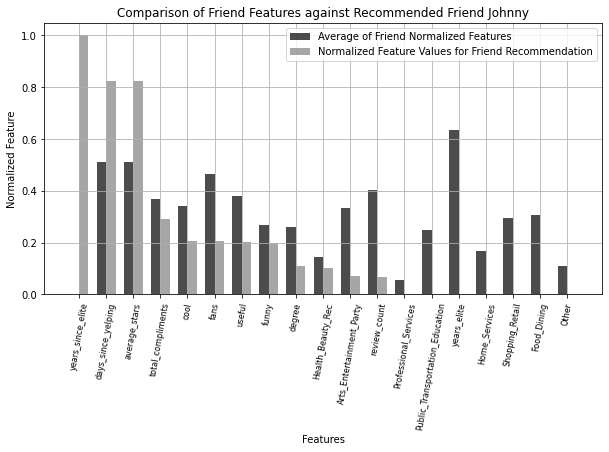

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'scaled_df' is already defined and contains the scaled features with 'node'
df = pd.DataFrame(scaled_df)

# Exclude rows 0 and 3, and exclude 'node' from averaging
filtered_df = df.drop([0, 3]).drop('node', axis=1)

# Calculate the average of the remaining features
average_values = filtered_df.mean()

# Extract the actual values from row index 3
actual_values_row3 = df.drop('node', axis=1).iloc[3]

# Combine the average and actual values into a DataFrame for sorting
comparison_df = pd.DataFrame({'Average': average_values, 'Actual': actual_values_row3})
comparison_df.sort_values('Actual', ascending=False, inplace=True)  # Sorting in descending order based on actual values

# Create a bar graph to compare the sorted averages with the sorted actual values of row index 3
fig, ax = plt.subplots(figsize=(10, 5))
index = range(len(comparison_df['Average']))
bar_width = 0.35

ax.bar(index, comparison_df['Average'], bar_width, label='Average of Friend Normalized Features', alpha=0.7, color="black")
ax.bar([p + bar_width for p in index], comparison_df['Actual'], bar_width, label='Normalized Feature Values for Friend Recommendation', alpha=0.7, color="grey")

plt.xlabel('Features')
plt.ylabel('Normalized Feature')
plt.title('Comparison of Friend Features against Recommended Friend Johnny')
plt.xticks([p + bar_width / 2 for p in index], comparison_df.index, rotation=80, fontsize=8)
plt.legend()
plt.grid(True)
plt.savefig("Images/model_analysis.png")  # Saves the plot to a file
plt.show()
